In [1]:
from scipy.spatial.distance import cdist
import commoncode as commoncode
import numpy as np
import matplotlib.pyplot as plt
import SkewGP as SkewGP
import GPy as GPy
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import norm
import pymc3 as pm

## 1D example
We define a function and use it to generate preferences

Text(0.5, 0, 'x')

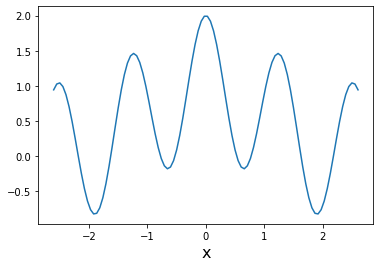

In [2]:
np.random.seed(42)
N=70
bounds=[[-2.6,2.6]]
x = np.linspace(-2.6,2.6,100)
def fun(x):
    return np.cos(x*5)+np.exp(-x**2/2)
plt.plot(x,fun(x))
plt.xlabel("x",fontsize=16)

In [3]:
n=50
X=np.vstack(bounds)[:,0]+np.random.rand(n,1)*(np.vstack(bounds)[:,1]-np.vstack(bounds)[:,0])

m=70 # number of preferences

W=[]
Pairs=[]
for ii in range(m):
    i=np.random.randint(X.shape[0])
    j=np.random.randint(X.shape[0])
    w=np.zeros((1,X.shape[0]),float)
    if fun(X[i])>fun(X[j]):
        w[:,i]=1
        w[:,j]=-1
        Pairs.append([i,j])# i is preferred to j
    else:
        w[:,i]=-1
        w[:,j]=1
        Pairs.append([j,i])# j is preferred to i
    W.append(w)
    
W=np.vstack(W)
Z=np.zeros((W.shape[0],1),float)

We define the Kernel and an empty skewness function for SkewGP. We are going to use  a zero dimension SkewGP, which is a GP prior and so we do not need Delta.

In [4]:
#define RBF kernel function
def Kernel(X1,X2,params,diag_=False):
    lengthscale=params['lengthscale']['value']
    variance   =params['variance']['value']
    if diag_==False:
        diffs = cdist(np.atleast_2d(X1)/ lengthscale, np.atleast_2d(X2) / lengthscale, metric='sqeuclidean')
    else:
        diffs = np.sum((np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale)*(np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale),axis=1)
    return variance * np.exp(-0.5 * diffs)
   
#define skewness function
def Delta(X,params):
    #empty
    return []

logexp=commoncode.logexp()
latent_dim=0

#Hyperparameters of the kernel
params0={'lengthscale': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.0001, 50.0]]),
                    'transform': logexp},
         'variance': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.001, 100.0]]),
                    'transform': logexp},
         'noise_variance': {'value':np.array([1.0]), #this is not used in classification
                    'range':np.vstack([[1.0, 1.0001]]),
                    'transform': logexp}
      }

We now need to define the matrix Z,W for the affine probit likelihood.

In [5]:
model = SkewGP.SkewGP(X,Kernel, Delta, params0, W=W, Z=Z,  latent_dim =latent_dim, type_y='affine', jitter=1e-6)
#we optimize the hyperparameters
ml=model.optimize(max_iters=1000) 
print("Marginal Likelihood",ml)

Iteration 0  -30.156235253979634
Marginal Likelihood -30.156235253979634


In [6]:
model.params

{'lengthscale': {'value': array([0.27950104]),
  'range': array([[1.e-04, 5.e+01]]),
  'transform': <commoncode.logexp at 0x7ff8c1eee460>},
 'variance': {'value': array([6.42563265]),
  'range': array([[1.e-03, 1.e+02]]),
  'transform': <commoncode.logexp at 0x7ff8c1eee460>},
 'noise_variance': {'value': array([1.]),
  'range': array([[1.    , 1.0001]]),
  'transform': <commoncode.logexp at 0x7ff8c1eee460>}}

Nowe we compute the predictions. The following code calls `lin-ess` sampler.

In [7]:
Xpred=np.linspace(-2.6,2.6,200)[:,None]
predictions=model.predict(Xpred,nsamples=10000)

Start Lin-Ess sampler
Progress: |██████████████████████████████████████████████████| 100.0% Complete


 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning:hpd will be deprecated Please replace hdi
 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning:hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


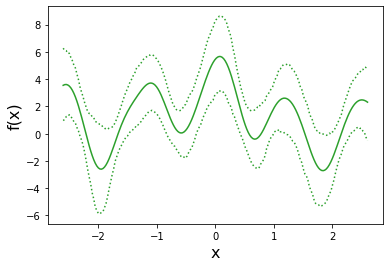

In [8]:
#we compute the credible intervals
credib_int = pm.stats.hpd(predictions.T)
#we plot the latent function mean and credible interval
plt.plot(Xpred[:,0],credib_int[:,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[:,0],color='C2', linestyle=':')
plt.plot(Xpred[:,0],np.mean(predictions,axis=1), label='mean',color='C2')
plt.xlabel("x",fontsize=16)
plt.ylabel("f(x)",fontsize=16);

In [9]:
indx = np.argmin((Xpred[:,0]-1.5)**2)
indx

157

We can  compute the posterior on the probability that f(x)-f(1.5)>=0

 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning:hpd will be deprecated Please replace hdi
 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning:hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


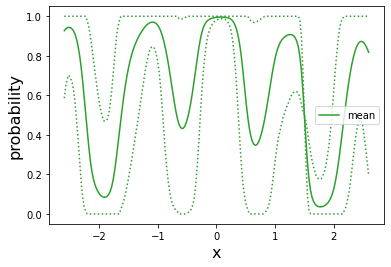

In [10]:
diff = predictions-predictions[indx,:]
prob_SGp = norm.cdf(diff)
credib_int = pm.stats.hpd(prob_SGp.T)
plt.plot(Xpred[:,0],np.mean(prob_SGp,axis=1),color='C2', label='mean')
plt.plot(Xpred[:,0],credib_int[:,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[:,0],color='C2', linestyle=':')
plt.xlabel("x",fontsize=16)
plt.ylabel("probability",fontsize=16)
plt.legend()

In [11]:
indx = np.argmin((Xpred[:,0]-0.0)**2)

Text(0.5, 0, 'f(0.0)-f(1.5)')

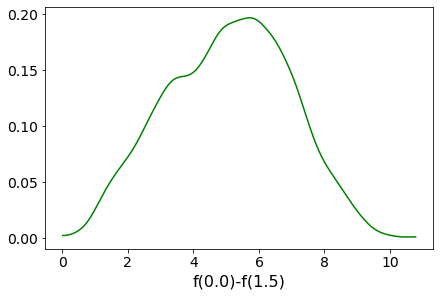

In [12]:
import arviz as az
az.plot_dist(diff[indx,:],color='g')
plt.xlabel("f(0.0)-f(1.5)",fontsize=16)